## System architecture

<img src = "System architecture.png">

## Loading training data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_parquet("train-00000-of-00001-c08a401c53fe5312.parquet")
data.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


## Data pre-processing

In [3]:
data.isnull().sum()

image    0
label    0
dtype: int64

In [5]:
import cv2

def bytes_to_image(d):
    if isinstance(d, dict) and "bytes" in d:
        bytes_ls = d["bytes"]
        np_ls = np.frombuffer(bytes_ls, np.uint8)
        image = cv2.imdecode(np_ls, cv2.IMREAD_GRAYSCALE)
        return image
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(d)}")

In [7]:
data["img_arr"] = data["image"].apply(bytes_to_image)
data.drop("image", axis = 1, inplace = True)
data.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [13]:
label_to_class_mapping = {0: "Mild_Demented", 1: "Moderate_Demented", 2: "Non_Demented", 3: "Very_Mild_Demented"}
data["class"] = data["label"].map(label_to_class_mapping)
data.head()

,label,img_arr,class
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mild_Demented
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented


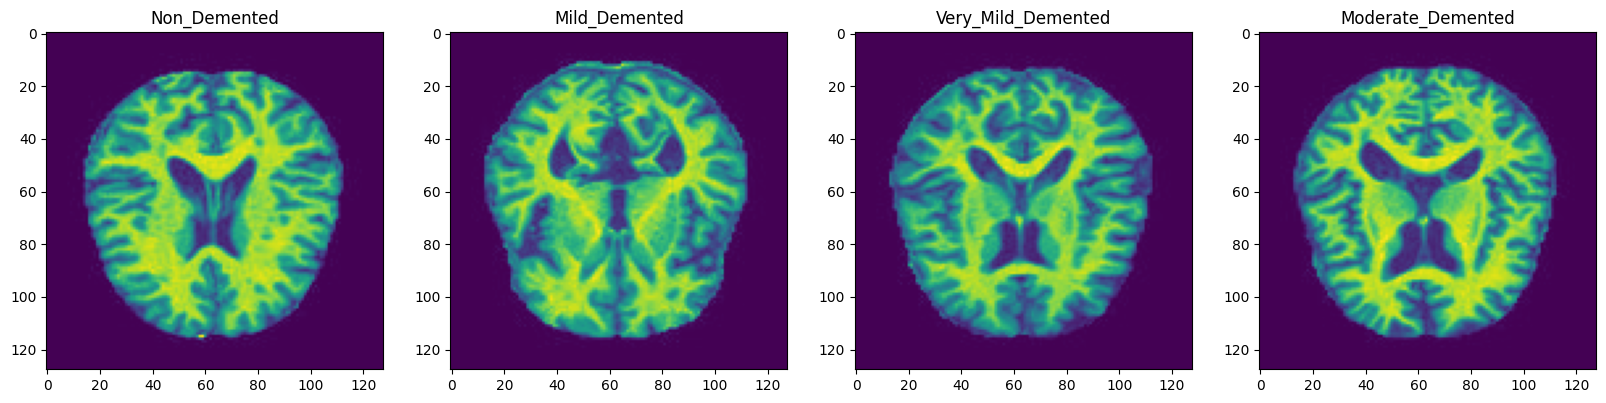

In [15]:
import matplotlib.pyplot as plt

set_labels = set()
image_indices = []

for i in range(len(data)):
    if (data.loc[i, "label"] not in set_labels):
        image_indices.append((data.loc[i, "class"], data.loc[i, "img_arr"]))
        set_labels.add(data.loc[i, "label"])
    elif (len(set_labels) == 4):
        break

fig, ax = plt.subplots(1, 4, figsize = (20, 10))

for i in range(4):
    ax[i].imshow(image_indices[i][1])
    ax[i].set_title(image_indices[i][0])

plt.show()

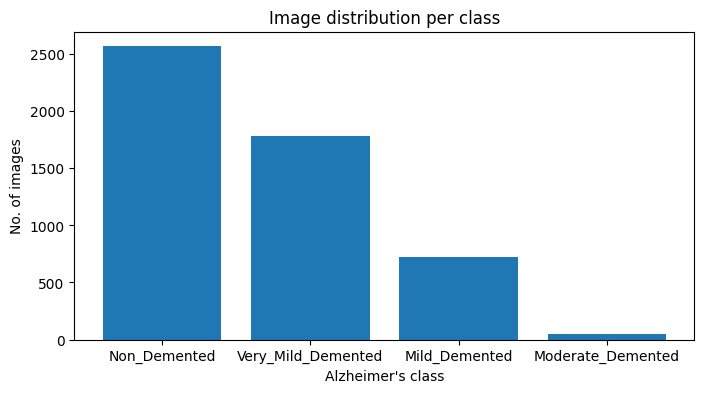

In [17]:
count = data.value_counts("class")

x = count.index
y = count.iloc[:]

fig = plt.figure(figsize=(8, 4))
plt.bar(x, y)
plt.xlabel("Alzheimer's class")
plt.ylabel("No. of images")
plt.title("Image distribution per class")
plt.show()

## Model training

In [19]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size = 0.2, stratify = data["class"], random_state = 42)

train_data.shape, val_data.shape

((4096, 3), (1024, 3))

In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight


X_train = np.stack(train_data["img_arr"].values)
y_train = train_data["label"].values
X_val = np.stack(val_data["img_arr"].values)
y_val = val_data["label"].values

X_train = X_train.reshape(-1, 128, 128, 1)
X_val = X_val.reshape(-1, 128, 128, 1)

class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train), y = y_train)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

print(class_weights_dict)

model = models.Sequential([
    layers.Conv2D(128, (3, 3), activation = "relu", input_shape = (128, 128, 1)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation = "relu"),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), activation = "relu"),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation = "relu"),
    layers.Dense(4, activation = "softmax")
])

model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

early_stop = EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

model.summary()

{0: 1.768566493955095, 1: 26.256410256410255, 2: 0.4987822698490015, 3: 0.7185964912280701}


C:\Users\Anjana\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 128)       │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         802,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 896,996 (3.42 MB)

 Trainable params: 896,996 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
history = model.fit(X_train, y_train, epochs = 50, validation_data = (X_val, y_val), callbacks = [early_stop], class_weight = class_weights_dict)

Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 44s 326ms/step - accuracy: 0.2904 - loss: 12.7606 - val_accuracy: 0.2588 - val_loss: 1.3838
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 45s 352ms/step - accuracy: 0.3550 - loss: 1.2319 - val_accuracy: 0.3936 - val_loss: 1.2623
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 44s 347ms/step - accuracy: 0.3969 - loss: 1.1149 - val_accuracy: 0.3721 - val_loss: 1.1663
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 46s 360ms/step - accuracy: 0.4779 - loss: 0.8930 - val_accuracy: 0.5654 - val_loss: 0.9147
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 48s 372ms/step - accuracy: 0.5537 - loss: 0.7274 - val_accuracy: 0.5996 - val_loss: 0.8648
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 53s 414ms/step - accuracy: 0.5791 - loss: 0.7350 - val_accuracy: 0.4932 - val_loss: 1.1534
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 53s 415ms/step - accuracy: 0.5644 - loss: 0.7539 - val_accuracy: 0.5566 - val_loss: 0.9134
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 56s 442ms/step - accuracy: 0.6618 - loss: 

## Model evaluation

In [90]:
model.evaluate(X_val, y_val)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.8773 - loss: 0.3177


[0.33102256059646606, 0.873046875]

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step
              precision    recall  f1-score   support

           0       0.77      0.92      0.84       145
           1       1.00      1.00      1.00        10
           2       0.89      0.90      0.89       513
           3       0.90      0.81      0.85       356

    accuracy                           0.87      1024
   macro avg       0.89      0.91      0.90      1024
weighted avg       0.88      0.87      0.87      1024



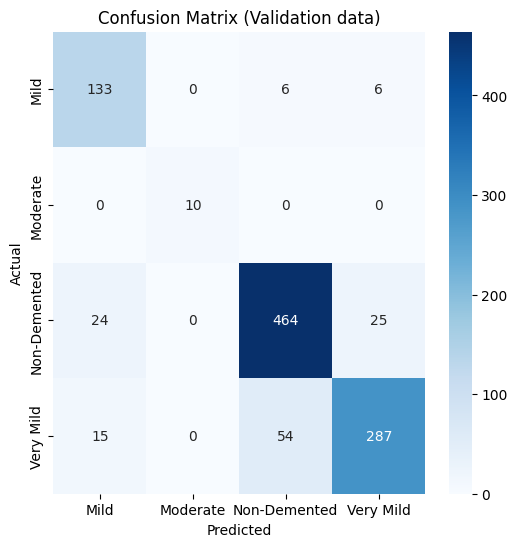

In [92]:
y_pred = np.argmax(model.predict(X_val), axis=1)
print(classification_report(y_val, y_pred))

plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_val, y_pred), annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Mild", "Moderate", "Non-Demented", "Very Mild"],
            yticklabels = ["Mild", "Moderate", "Non-Demented", "Very Mild"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation data)")
plt.show()

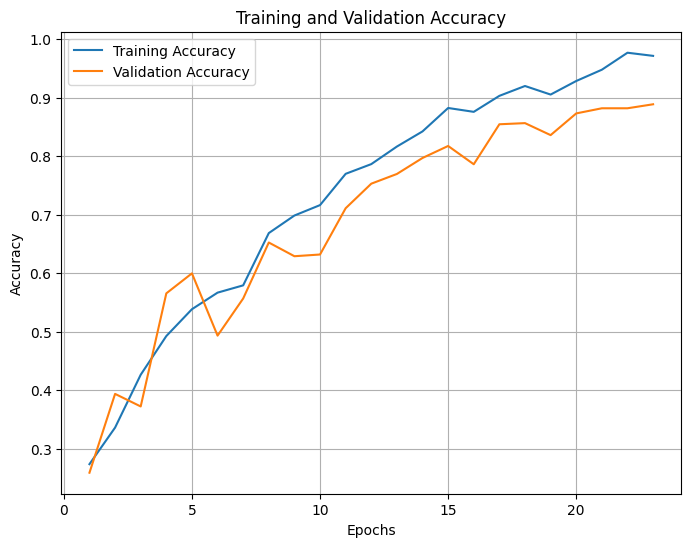

In [94]:
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize = (8, 6))
plt.plot(epochs, train_accuracy, label = "Training Accuracy")
plt.plot(epochs, val_accuracy, label = "Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## Model prediction

In [96]:
test_data = pd.read_parquet("test-00000-of-00001-44110b9df98c5585.parquet")
test_data.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [98]:
test_data["img_arr"] = test_data["image"].apply(bytes_to_image)
test_data.drop("image", axis = 1, inplace = True)
test_data.head()

,label,img_arr
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [100]:
test_data["class"] = test_data["label"].map(label_to_class_mapping)
test_data.head()

,label,img_arr,class
0,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mild_Demented
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Non_Demented
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Very_Mild_Demented
4,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",Mild_Demented


In [102]:
test_data.value_counts("label")

label
2    634
3    459
0    172
1     15
Name: count, dtype: int64

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       172
           1       1.00      0.87      0.93        15
           2       0.85      0.92      0.89       634
           3       0.90      0.78      0.84       459

    accuracy                           0.87      1280
   macro avg       0.90      0.87      0.88      1280
weighted avg       0.87      0.87      0.87      1280



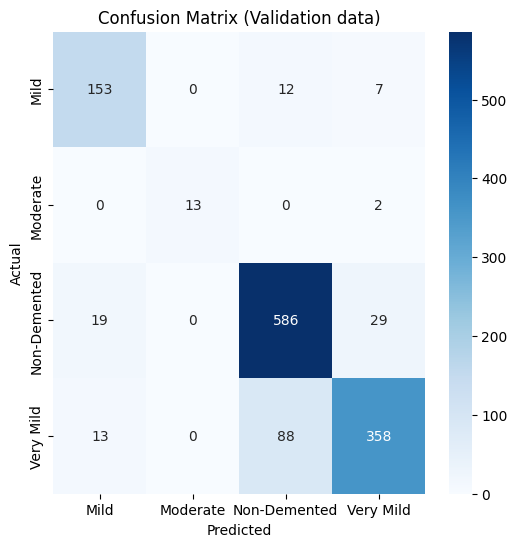

In [104]:
X_test = np.stack(test_data["img_arr"].values)
y_test = test_data["label"].values

X_test = X_test.reshape(-1, 128, 128, 1)

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(y_test, y_pred))

plt.figure(figsize = (6,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, fmt = "d", cmap = "Blues",
            xticklabels = ["Mild", "Moderate", "Non-Demented", "Very Mild"],
            yticklabels = ["Mild", "Moderate", "Non-Demented", "Very Mild"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Validation data)")
plt.show()

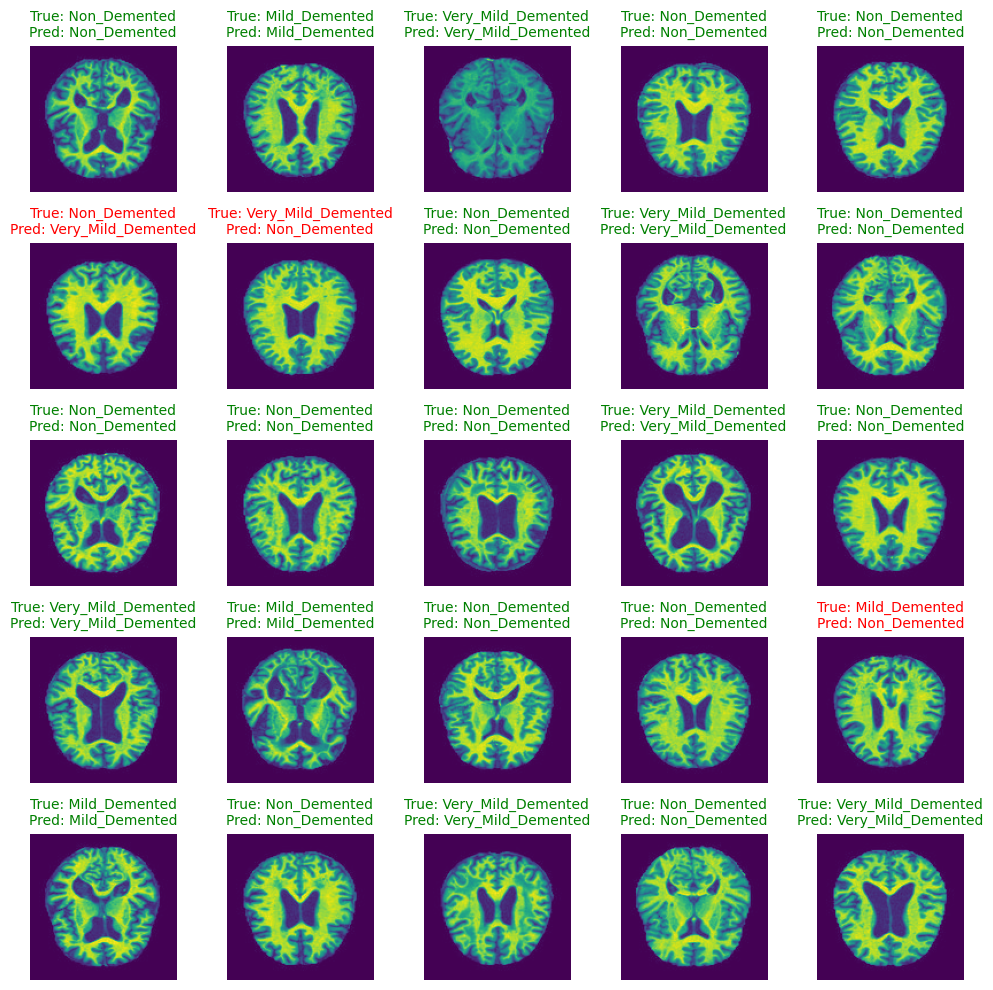

In [106]:
indices = np.random.choice(X_test.shape[0], 25, replace=False)
images = X_test[indices]
true_labels = y_test[indices]
pred_labels = y_pred[indices]

fig, ax = plt.subplots(5, 5, figsize = (10, 10))
for ax, img, true_label, pred_label in zip(ax.flat, images, true_labels, pred_labels):
    ax.imshow(img)
    ax.set_title(f"True: {label_to_class_mapping[true_label]}\nPred: {label_to_class_mapping[pred_label]}", fontsize = 10, color = "green" if (true_label == pred_label) else "red")
    ax.axis('off')

plt.tight_layout()
plt.show()